In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import talib
import functions
from backtesting import Backtest, Strategy

In [37]:
_df = functions.get_data('2454.TW', '2017-05-25', '2022-05-26')
_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock splits,Foreign,Trust,Dealer,Total
Date,,,,,,,,,,,
2017-05-25,192.774868,197.926981,189.769470,196.209610,23568000,0.0,0,8029,286,884,9199
2017-05-26,197.068298,198.356326,195.350928,197.068298,12758000,0.0,0,3698,659,-1264,3093
2017-05-31,197.497635,199.215006,196.638950,197.497635,11672000,0.0,0,1618,108,-194,1532
2017-06-01,197.497644,198.356330,195.350931,195.780273,5294000,0.0,0,315,0,-213,102
2017-06-02,197.497632,202.649744,197.068289,200.932373,11260000,0.0,0,1989,126,1543,3658


In [38]:
chip_df = functions.chip_signal(_df.copy())

### MACD

In [39]:
class MACD(Strategy):
    
    short_ema = 0
    long_ema = 0
    
    def init(self):
        super().init()

        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        dif, dea, macd = talib.MACD(close, fastperiod=self.short_ema, slowperiod=self.long_ema)
        
        # Precompute signal
        signal_long = (dif.shift() < macd.shift()) & (dif > macd)
        signal_short = (dif.shift() > macd.shift()) & (dif < macd)

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # plot
        self.I(lambda x: macd, 'MACD')
        self.I(lambda x: dif, 'DIF')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()
        
        entry_size = self.signal[-1]
        price = self.data.Close[-1]
        
        # long/short SL and TP
        long_sl = price * 0.85
        long_tp = price * 1.15
        short_sl = price * 1.15
        short_tp = price * 0.85
        
        if entry_size > 0: 
            self.buy()
        elif entry_size < 0: 
            for trade in self.trades:
                trade.close()
                
        """
        if entry_size > 0:
            self.buy(size = 0.3, sl = long_sl, tp = long_tp)
        elif entry_size < 0:
            # sell all
            for trade in self.trades:
                trade.close()
            self.sell(size = 0.3, sl = short_sl, tp = short_tp)
        """

In [40]:
class MACD_chip(Strategy):
    
    short_ema = 0
    long_ema = 0
    
    def init(self):
        super().init()

        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        dif, dea, macd = talib.MACD(close, fastperiod=self.short_ema, slowperiod=self.long_ema)
        
        # Precompute signal
        signal_long = (dif.shift() < macd.shift()) & (dif > macd)
        signal_short = (dif.shift() > macd.shift()) & (dif < macd)

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # combine chip signal
        chip_signal = pd.Series(self.data.ChipSignal)
        
        for i in range(len(chip_signal)):
            if chip_signal[i] == 1:
                signal[i] = 1
            elif chip_signal[i] == -1:
                signal[i] = -1
        
        # plot
        self.I(lambda x: macd, 'MACD')
        self.I(lambda x: dif, 'DIF')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()
        
        entry_size = self.signal[-1]
        price = self.data.Close[-1]
        
        # long/short SL and TP
        long_sl = price * 0.85
        long_tp = price * 1.15
        short_sl = price * 1.15
        short_tp = price * 0.85
        
        if entry_size > 0: 
            self.buy()
        elif entry_size < 0: 
            for trade in self.trades:
                trade.close()
                
        """
        if entry_size > 0:
            self.buy(size = 0.3, sl = long_sl, tp = long_tp)
        elif entry_size < 0:
            # sell all
            for trade in self.trades:
                trade.close()
            self.sell(size = 0.3, sl = short_sl, tp = short_tp)
        """

In [41]:
bt_macd = Backtest(_df, MACD, cash=100000, commission=0.001425, trade_on_close=True)
result_macd = bt_macd.run(short_ema=12, long_ema=26)
bt_macd.plot()

Row(id='11106', ...)

<AxesSubplot:>

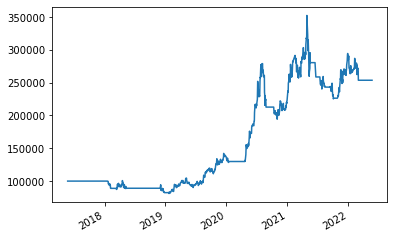

In [42]:
result_macd._equity_curve.Equity.plot()

#### Comparing default params with shorter range btw `short_ema` & `long_ema`

<AxesSubplot:>

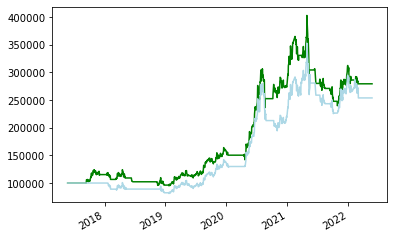

In [43]:
result_macd_1015 = bt_macd.run(short_ema=10, long_ema=15)
result_macd_1015._equity_curve.Equity.plot(color='green')
result_macd._equity_curve.Equity.plot(color='lightblue')

#### Parameters Optimization

In [44]:
result_macd_opt = bt_macd.optimize(short_ema=range(5, 200, 5),
                                   long_ema=range(5, 200, 5))
result_macd_opt._strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 1521 configurations.
  output = _optimize_grid()
/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/11 [00:00<?, ?it/s]

<Strategy MACD(short_ema=25,long_ema=110)>

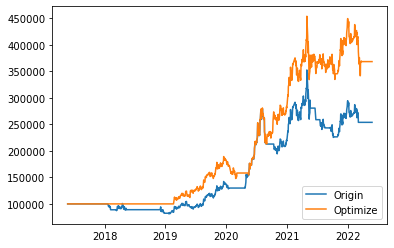

In [45]:
plt.figure()
plt.plot(result_macd._equity_curve.Equity, label='Origin')
plt.plot(result_macd_opt._equity_curve.Equity, label='Optimize')
plt.legend(loc='lower right')
plt.show()

### Chip Analysis

In [46]:
bt_macd_chip = Backtest(chip_df, MACD_chip, cash=100000, commission=0.001425, trade_on_close=True)
result_macd_chip = bt_macd_chip.run(short_ema=12, long_ema=26)
bt_macd_chip.plot()

Row(id='12161', ...)

In [47]:
result_macd_chip = bt_macd.optimize(short_ema=range(5, 200, 5),
                                    long_ema=range(5, 200, 5))
result_macd_chip._strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 1521 configurations.
  output = _optimize_grid()
/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/11 [00:00<?, ?it/s]

<Strategy MACD(short_ema=25,long_ema=110)>

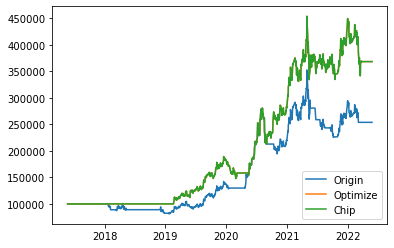

In [48]:
plt.figure()
plt.plot(result_macd._equity_curve.Equity, label='Origin')
plt.plot(result_macd_opt._equity_curve.Equity, label='Optimize')
plt.plot(result_macd_chip._equity_curve.Equity, label='Chip')
plt.legend(loc='lower right')
plt.show()